In [28]:
import random
import numpy as np

demo_types = ['continuous', 'categorical', 'categorical', 'categorical']
demo = [[], [], [], []]
N = 1000

for i in range(N):
    age = random.randint(15,65)
    sex = random.randint(0,1)
    race = random.randint(0,1)
    diag = random.randint(0,1)*3 # 0 SZP or 3 NC/Relative
    demo[0].append(age)
    demo[1].append(sex)
    demo[2].append(race)
    demo[3].append(diag)

fc = {'Baltimore': [], 'Chicago': [], 'Dallas': [], 'Detroit': [], 'Hartford': []}

for i in range(len(demo)):
    demo[i] = np.array(demo[i])

print('Done')

Done


In [29]:
from demovae import DemoVAE

for loc in fc.keys():
    path = f'/home/anton/Documents/Tulane/Research/FederatedVAE/BSNIP_Models/{loc}.pkl'
    
    vae = DemoVAE(pperiod=100, use_cuda=True, nepochs=5000, latent_dim=30, weight_decay=0, lr=5e-5, loss_rec_mult=500, loss_pred_mult=.01)
    vae.load(path)
    fc[loc] = vae.transform(N, demo, demo_types)
    print(fc[loc].shape)

(1000, 34716)
(1000, 34716)
(1000, 34716)
(1000, 34716)
(1000, 34716)


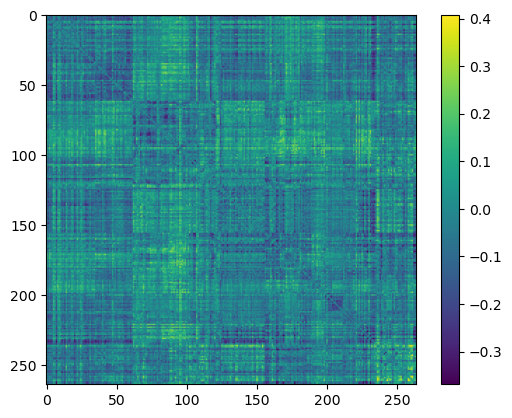

In [50]:
import matplotlib.pyplot as plt

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

site_fcs = []

for k,v in fc.items():
    site_fcs.append(vec2mat(np.mean(v, axis=0)))

# plt.imshow(np.std(np.stack(site_fcs), axis=0))
plt.imshow(site_fcs[0]-site_fcs[1])
plt.colorbar()

In [40]:
# Get the true site differences

ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


In [41]:
sites = ['Baltimore', 'Chicago', 'Dallas', 'Detroit',  'Hartford']
test_site = 'None'

train_fcs = [[], [], [], [], []]
train_labels = [[], [], [], [], []]

test_fcs = []
test_labels = []

import pickle
import numpy as np

diag_map = {'SZP': 0, 'BPP': 1, 'SADBPP': 2, 'SADDEPP': 2, 'NC': 3, 'SADDEPR': 3, 'SADBPR': 3, 'BPR': 3, 'SZR': 3} 

bsnipdir = '/home/anton/Documents/Tulane/Research/data-sav/anton/cohorts/BSNIP/'
bsnip = pickle.load(open(f'{bsnipdir}/demographics.pkl', 'rb'))

a,b = np.triu_indices(264,1)

for sub in bsnip['Age_cal']:
    parts = sub.split('.')
    diag = bsnip['DXGROUP_1'][sub]
    diag = diag_map[diag]
    if diag != 0 and diag != 3:
        continue
    diag = int(diag == 3)
    p = np.load(f'{bsnipdir}/fc/{sub}_task-unk_fc.npy')
    p = remap(vec2mat(p))[a,b]
    if parts[0] == test_site:
        test_fcs.append(p)
        test_labels.append(diag)
    else:
        for i in range(len(sites)):
            if parts[0] == sites[i]:
                train_fcs[i].append(p)
                train_labels[i].append(diag)
                break

for i in range(len(sites)):
    train_fcs[i] = np.stack(train_fcs[i])
    train_labels[i] = np.array(train_labels[i])
    print(train_fcs[i].shape)
    print(train_labels[i])

(226, 34716)
[0 0 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0 1 1 1 0 0 0 1 1 0 1 0 0 1 1 1 0 1 1 1 1 1
 1 0 1 0 1 1 1 1 0 0 0 1 1 0 0 0 1 1 1 1 0 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1
 1 1 1 0 1 1 0 1 1 0 0 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1
 1 1 0 1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 1
 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1
 1 1 1 1]
(161, 34716)
[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1
 1 0 0 1 1 0 0 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 1 0 1
 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1 1
 0 1 1 1 1 1 1 1 1 0 1 1 0]
(162, 34716)
[1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 0 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 

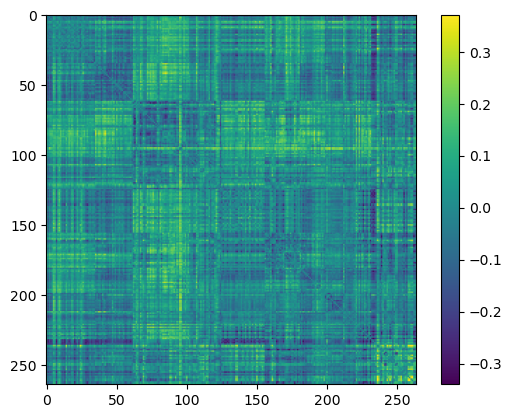

In [51]:
tsite_fcs = []

for v in train_fcs:
    tsite_fcs.append(vec2mat(np.mean(v, axis=0)))

# plt.imshow(np.std(np.stack(site_fcs), axis=0))
plt.imshow(tsite_fcs[0]-tsite_fcs[1])
plt.colorbar()